In [9]:
import pandas as pd

# Define your base project path
base_path = r"E:\Documents\Parth\Careers\Projects"

# Load CSVs
customer_df = pd.read_csv(f"{base_path}\\CustomerProfile.csv")
usage_df = pd.read_csv(f"{base_path}\\LicenseUsage.csv", parse_dates=['LoginDate'])
support_df = pd.read_csv(f"{base_path}\\SupportTickets.csv", parse_dates=['Date'], dayfirst=True)
engage_df = pd.read_csv(f"{base_path}\\EngagementData.csv", parse_dates=['LastMeetingDate'], dayfirst=True)

In [11]:
usage_summary = usage_df.groupby(['ClientID', 'Product']).size().reset_index(name='UsageCount')

In [13]:
client_usage = usage_df.groupby('ClientID').size().reset_index(name='TotalUsage')
quantiles = client_usage['TotalUsage'].quantile([0.2, 0.8])
low_threshold = quantiles[0.2]
high_threshold = quantiles[0.8]

client_usage['UsageTier'] = client_usage['TotalUsage'].apply(
    lambda x: 'Bottom 20%' if x <= low_threshold else ('Top 20%' if x >= high_threshold else 'Middle 60%')
)

In [15]:
# Total support volume per client
support_summary = support_df.groupby('ClientID').agg({
    'TicketID': 'count',
    'ResolutionTimeHours': 'mean'
}).rename(columns={'TicketID': 'TotalTickets', 'ResolutionTimeHours': 'AvgResolutionTime'})

# Merge with engagement data
engage_df['FollowUps'] = engage_df['FollowUps'].fillna(0)
engage_df['DemosHeld'] = engage_df['DemosHeld'].fillna(0)
engage_df['EngagementScore'] = engage_df['DemosHeld'] + engage_df['FollowUps']

engage_support = pd.merge(engage_df, support_summary, on='ClientID', how='left').fillna(0)

In [17]:
# Merge license data
license_summary = pd.merge(customer_df[['ClientID', 'LicensesPurchased']], client_usage, on='ClientID', how='left').fillna(0)
license_summary['IdleLicenses'] = license_summary['LicensesPurchased'] - license_summary['TotalUsage']

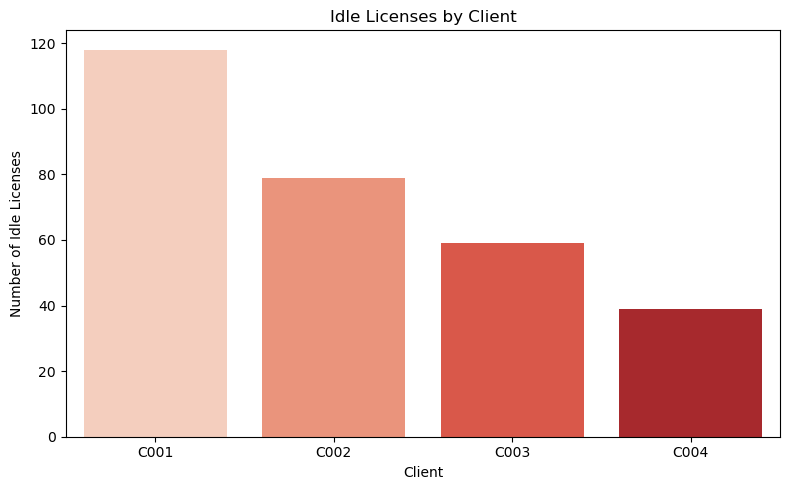

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(
    data=license_summary,
    x='ClientID',
    y='IdleLicenses',
    hue='ClientID',           # Add this
    palette='Reds',
    legend=False              # And this
)
plt.title('Idle Licenses by Client')
plt.ylabel('Number of Idle Licenses')
plt.xlabel('Client')
plt.tight_layout()
plt.show()

In [23]:
# Define risk criteria
def risk_flag(row):
    return '⚠️ At Risk' if (row['EngagementScore'] <= 2 and row['TotalTickets'] >= 2 and row['TotalUsage'] <= 20) else '✅ Healthy'

# Merge all data together
merged_df = customer_df.merge(client_usage, on='ClientID', how='left').merge(engage_support, on='ClientID', how='left')
merged_df['RiskStatus'] = merged_df.apply(risk_flag, axis=1)

# Display Risk Summary
print(merged_df[['ClientID', 'CompanyName', 'TotalUsage', 'EngagementScore', 'TotalTickets', 'RiskStatus']])

  ClientID       CompanyName  TotalUsage  EngagementScore  TotalTickets  \
0     C001  MechInnovate Ltd           2                8           2.0   
1     C002    AeroStruct Inc           1                2           0.0   
2     C003         BuildCore           1                6           1.0   
3     C004       RapidTorque           1                3           1.0   

  RiskStatus  
0  ✅ Healthy  
1  ✅ Healthy  
2  ✅ Healthy  
3  ✅ Healthy  
